In [3]:
import numpy as np
import json
from pymatgen.core.structure import Structure
from smol.io import load_work, save_work
import os
from smol.moca import Ensemble
from smol.moca import Sampler
from smol.capp.generate import generate_random_ordered_occupancy
from matplotlib import pyplot as plt
import random

# create cluster expansion from scratch using modules 
import sys 
sys.path.append('../Modules')
from cluster_creator import prim_entry_dataloader, cluster_subspace_creator, structure_wrangler_creator 
from eci_fitter import eci_fitter
from structure_generation import create_cca_primitive, closest_composition

In [ ]:
# get the compositions 

In [5]:
# get a list of all the ensembles in the directory 
#expansion_path = '../Expansions/VCrTiWZr'
expansion_path = '../Expansions/VCrTi_Fixed_125'

# get a list of all the ensembles in the directory
expansion_list = []
for root, dirs, files in os.walk(expansion_path):
    for file in files:
        if file.endswith('.mson'):
            expansion_list.append(os.path.join(root, file))

print(expansion_list)

['../Expansions/VCrTi_Fixed_125/V0_75-Cr0_177-Ti0_073_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_604-Cr0_301-Ti0_095_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_784-Cr0_056-Ti0_16_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_762-Cr0_127-Ti0_111_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_766-Cr0_161-Ti0_073_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_754-Cr0_056-Ti0_19_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_936-Cr0_024-Ti0_04_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_8-Cr0_072-Ti0_128_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_936-Cr0_016-Ti0_048_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_816-Cr0_072-Ti0_112_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_728-Cr0_112-Ti0_16_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_808-Cr0_168-Ti0_024_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_738-Cr0_167-Ti0_095_fin_work.mson', '../Expansions/VCrTi_Fixed_125/V0_816-Cr0_032-Ti0_152_fin_work.mson', '../Expansions/VCrTi_Fixed

In [19]:
expansion_list = ['../Expansions/VCrTi_Fixed_64/V0_90625-Cr0_046875-Ti0_046875_fin_work.mson']

The supercell size for the processor is 125 prims.
The ensemble has a total of 125 sites.
The active sublattices are:
Sublattice(site_space=V0.75 Cr0.177 Ti0.073 , sites=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124]), active_sites=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:45<00:00, 22111.40it/s]


Fraction of successful steps (efficiency) 0.001306
The last step energy is -1126.8269017965147 eV
The minimum energy in trajectory is -1128.3237840389788 eV
[-1125.52770791 -1126.07765011 -1126.22376394 ... -1126.33906555
 -1126.88364622 -1126.8269018 ]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1126.809447262182 eV
The energy variance is 0.19657881402081476 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0012941294129412942
Full Formula (Ti9 V94 Cr22)
Reduced Formula: Ti9(V47Cr11)2
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Cr    0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  Ti    0    0    0.8
  5  Ti    0    0.2  0
  6  Cr    0    0.2  0.2
  7  Cr    0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:42<00:00, 23266.54it/s]


Fraction of successful steps (efficiency) 0.00066
The last step energy is -1108.3185440122124 eV
The minimum energy in trajectory is -1108.6621099475042 eV
[-1099.69021899 -1101.34867359 -1102.66957731 ... -1108.18145107
 -1108.05938786 -1108.31854401]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1107.9671669241038 eV
The energy variance is 0.0621806544913168 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0006570657065706571
Full Formula (Ti20 V98 Cr7)
Reduced Formula: Ti20(V14Cr)7
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ti    0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  Ti 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:42<00:00, 23703.01it/s]


Fraction of successful steps (efficiency) 0.000756
The last step energy is -1118.6271224805917 eV
The minimum energy in trajectory is -1119.7699183115794 eV
[-1114.5658985  -1115.95914661 -1116.31739977 ... -1118.23329483
 -1118.65434712 -1118.62712248]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1118.3140123981316 eV
The energy variance is 0.261243743704117 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0007510751075107511
Full Formula (Ti14 V95 Cr16)
Reduced Formula: Ti14V95Cr16
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 24137.70it/s]


Fraction of successful steps (efficiency) 0.001272
The last step energy is -1125.1000520912696 eV
The minimum energy in trajectory is -1127.0544781483445 eV
[-1122.29295271 -1123.67736771 -1124.4791042  ... -1125.48300359
 -1125.72336685 -1125.10005209]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1125.4029615566305 eV
The energy variance is 0.19478680795529776 eV^2
The sampling efficiency (acceptance rate) is approximately 0.001261126112611261
Full Formula (Ti9 V96 Cr20)
Reduced Formula: Ti9(V24Cr5)4
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  Cr    0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  Ti

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:43<00:00, 23070.71it/s]


Fraction of successful steps (efficiency) 0.000291
The last step energy is -1104.5402561258566 eV
The minimum energy in trajectory is -1105.2817736889003 eV
[-1093.8534151  -1096.98107639 -1099.50946551 ... -1104.58145993
 -1104.54025613 -1104.54025613]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1104.5544681173287 eV
The energy variance is 0.10770900363483152 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00028702870287028703
Full Formula (Ti24 V94 Cr7)
Reduced Formula: Ti24V94Cr7
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Ti    0    0    0.4
  3  Cr    0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  Ti

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:42<00:00, 23611.64it/s]


Fraction of successful steps (efficiency) 0.000681
The last step energy is -1120.3670206964764 eV
The minimum energy in trajectory is -1120.4841745686435 eV
[-1119.53462765 -1119.66611686 -1119.60336604 ... -1119.67554562
 -1119.7856511  -1120.3670207 ]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1119.9042590424522 eV
The energy variance is 0.08369230770853447 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0006770677067706771
Full Formula (Ti5 V117 Cr3)
Reduced Formula: Ti5(V39Cr)3
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 24331.03it/s]


Fraction of successful steps (efficiency) 0.000474
The last step energy is -1112.5043250301972 eV
The minimum energy in trajectory is -1112.9693503333929 eV
[-1105.8379131  -1108.89618236 -1109.37137259 ... -1112.42057819
 -1112.49720482 -1112.50432503]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1112.1219166770406 eV
The energy variance is 0.12897260262080049 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00046904690469046906
Full Formula (Ti16 V100 Cr9)
Reduced Formula: Ti16V100Cr9
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:42<00:00, 23286.03it/s]


Fraction of successful steps (efficiency) 0.00036
The last step energy is -1118.2330288090345 eV
The minimum energy in trajectory is -1118.6788053447262 eV
[-1117.54490536 -1117.77557165 -1117.84960227 ... -1117.96039175
 -1118.00748268 -1118.23302881]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1118.3134963827931 eV
The energy variance is 0.10093243639659762 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000354035403540354
Full Formula (Ti6 V117 Cr2)
Reduced Formula: Ti6V117Cr2
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V    

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 23881.49it/s]


Fraction of successful steps (efficiency) 0.000599
The last step energy is -1113.5211621211897 eV
The minimum energy in trajectory is -1114.6222089584294 eV
[-1108.7733577  -1110.3498209  -1111.23253189 ... -1113.26678988
 -1113.34426907 -1113.52116212]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1113.6272760050986 eV
The energy variance is 0.16406228884386548 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0005910591059105911
Full Formula (Ti14 V102 Cr9)
Reduced Formula: Ti14(V34Cr3)3
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  Cr    0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 23890.77it/s]


Fraction of successful steps (efficiency) 0.000646
The last step energy is -1112.3887604919732 eV
The minimum energy in trajectory is -1114.0141918092697 eV
[-1105.11948536 -1107.6099377  -1108.35582083 ... -1112.27568869
 -1112.24518621 -1112.38876049]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1112.7697676142961 eV
The energy variance is 0.24909674545041194 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0006450645064506451
Full Formula (Ti20 V91 Cr14)
Reduced Formula: Ti20(V13Cr2)7
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  Cr    0    0    0.6
  4  V     0    0    0.8
  5  Cr    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  Ti    0    0.2  0.8
 10 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:42<00:00, 23559.09it/s]


Fraction of successful steps (efficiency) 0.001544
The last step energy is -1133.9573298126318 eV
The minimum energy in trajectory is -1134.4356440625124 eV
[-1131.74020102 -1132.13982336 -1132.07867903 ... -1133.28610141
 -1133.40967516 -1133.95732981]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1132.9472462942028 eV
The energy variance is 0.27737886891520475 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0015281528152815281
Full Formula (Ti3 V101 Cr21)
Reduced Formula: Ti3V101Cr21
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  Cr    0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  Cr    0    0.2  0.8
 10  T

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:40<00:00, 24443.59it/s]


Fraction of successful steps (efficiency) 0.001028
The last step energy is -1123.6983126105038 eV
The minimum energy in trajectory is -1124.8235115763825 eV
[-1119.31227996 -1120.81614802 -1120.96479869 ... -1123.73687454
 -1123.73696146 -1123.69831261]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1123.434095849083 eV
The energy variance is 0.26650392840966525 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00102010201020102
Full Formula (Ti12 V92 Cr21)
Reduced Formula: Ti12V92Cr21
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  Cr    0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V   

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25449.43it/s]


Fraction of successful steps (efficiency) 0.000471
The last step energy is -1106.9099820991191 eV
The minimum energy in trajectory is -1107.2494589615485 eV
[-1099.45093998 -1103.39320287 -1103.64432163 ... -1106.75164783
 -1106.9099821  -1106.9099821 ]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1106.8443727304737 eV
The energy variance is 0.06782529675036461 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00046804680468046805
Full Formula (Ti19 V102 Cr4)
Reduced Formula: Ti19(V51Cr2)2
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 24243.44it/s]


Fraction of successful steps (efficiency) 0.001016
The last step energy is -1121.1261945045783 eV
The minimum energy in trajectory is -1122.4442383968778 eV
[-1121.23162608 -1121.77085708 -1121.30587472 ... -1121.72746159
 -1121.6861061  -1121.1261945 ]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1121.740843099404 eV
The energy variance is 0.07756564648593879 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00101010101010101
Full Formula (Ti4 V117 Cr4)
Reduced Formula: Ti4V117Cr4
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  Ti    0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V     

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 24386.15it/s]


Fraction of successful steps (efficiency) 0.001891
The last step energy is -1131.5709490143215 eV
The minimum energy in trajectory is -1132.7651778828363 eV
[-1131.12882661 -1130.50985604 -1131.69015359 ... -1131.79306023
 -1132.01055134 -1131.57094901]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1131.5281458636475 eV
The energy variance is 0.17274273966709952 eV^2
The sampling efficiency (acceptance rate) is approximately 0.001867186718671867
Full Formula (Ti1 V110 Cr14)
Reduced Formula: Ti(V55Cr7)2
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Ti    0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  Cr    0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 23985.04it/s]


Fraction of successful steps (efficiency) 0.000407
The last step energy is -1117.5417534244557 eV
The minimum energy in trajectory is -1119.506262240442 eV
[-1106.7998581  -1107.70329287 -1109.09199257 ... -1117.18126463
 -1117.30057275 -1117.54175342]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1117.7764687217477 eV
The energy variance is 0.3226655489443313 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000402040204020402
Full Formula (Ti23 V79 Cr23)
Reduced Formula: Ti23V79Cr23
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Cr    0    0    0.4
  3  Cr    0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  V   

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 23952.96it/s]


Fraction of successful steps (efficiency) 0.000484
The last step energy is -1111.93561387763 eV
The minimum energy in trajectory is -1112.6194734326675 eV
[-1107.55292091 -1107.94664662 -1110.4308457  ... -1111.55783577
 -1111.92471124 -1111.93561388]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1111.7594595182034 eV
The energy variance is 0.14475975521930576 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00047704770477047703
Full Formula (Ti14 V105 Cr6)
Reduced Formula: Ti14(V35Cr2)3
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:45<00:00, 22119.41it/s]


Fraction of successful steps (efficiency) 0.00103
The last step energy is -1118.7992912451705 eV
The minimum energy in trajectory is -1120.485511706801 eV
[-1115.98258994 -1116.79630926 -1116.12785655 ... -1119.35458863
 -1119.36706902 -1118.79929125]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1119.261229278784 eV
The energy variance is 0.14591485500783488 eV^2
The sampling efficiency (acceptance rate) is approximately 0.001012101210121012
Full Formula (Ti10 V103 Cr12)
Reduced Formula: Ti10V103Cr12
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:44<00:00, 22539.59it/s]


Fraction of successful steps (efficiency) 0.001342
The last step energy is -1128.9945097530474 eV
The minimum energy in trajectory is -1130.6108869787693 eV
[-1128.20332255 -1128.06847699 -1128.69768612 ... -1129.03740854
 -1129.19818898 -1128.99450975]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1129.0550727355487 eV
The energy variance is 0.28022310451993615 eV^2
The sampling efficiency (acceptance rate) is approximately 0.001329132913291329
Full Formula (Ti4 V104 Cr17)
Reduced Formula: Ti4V104Cr17
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Cr    0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 23946.58it/s]


Fraction of successful steps (efficiency) 0.000462
The last step energy is -1110.2258351428534 eV
The minimum energy in trajectory is -1110.809581249877 eV
[-1104.12789207 -1104.58877045 -1105.34497693 ... -1109.90408974
 -1109.88786392 -1110.22583514]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1109.980452103939 eV
The energy variance is 0.15379707938114454 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00045604560456045603
Full Formula (Ti17 V101 Cr7)
Reduced Formula: Ti17V101Cr7
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 24156.22it/s]


Fraction of successful steps (efficiency) 0.000597
The last step energy is -1119.6732081793957 eV
The minimum energy in trajectory is -1121.390686056765 eV
[-1112.68985338 -1116.49578886 -1116.90357421 ... -1119.82685085
 -1119.70349455 -1119.67320818]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1119.765277757457 eV
The energy variance is 0.2844618690005501 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000589058905890589
Full Formula (Ti17 V87 Cr21)
Reduced Formula: Ti17(V29Cr7)3
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  Ti    0    0    0.6
  4  V     0    0    0.8
  5  Ti    0    0.2  0
  6  Cr    0    0.2  0.2
  7  Ti    0    0.2  0.4
  8  V     0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  Cr 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:40<00:00, 24605.92it/s]


Fraction of successful steps (efficiency) 0.000644
The last step energy is -1114.7622638866815 eV
The minimum energy in trajectory is -1116.1577240985919 eV
[-1110.00625548 -1111.24870722 -1112.31237055 ... -1115.2628205
 -1115.34850013 -1114.76226389]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1114.9053491785291 eV
The energy variance is 0.20471726247504454 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0006350635063506351
Full Formula (Ti14 V100 Cr11)
Reduced Formula: Ti14V100Cr11
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  Cr    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:40<00:00, 24688.59it/s]


Fraction of successful steps (efficiency) 0.000406
The last step energy is -1118.613551946467 eV
The minimum energy in trajectory is -1119.9718316963485 eV
[-1109.72654391 -1109.89268672 -1110.95461052 ... -1119.20590002
 -1118.98875197 -1118.61355195]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1118.5348300225885 eV
The energy variance is 0.29870066572843235 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00040104010401040106
Full Formula (Ti22 V80 Cr23)
Reduced Formula: Ti22V80Cr23
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  Ti    0    0.2  0.4
  8  V     0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  T

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 24360.33it/s]


Fraction of successful steps (efficiency) 0.000449
The last step energy is -1116.1601413627407 eV
The minimum energy in trajectory is -1116.5652853159431 eV
[-1104.1041756  -1107.22261868 -1109.1408883  ... -1116.02269624
 -1116.16014136 -1116.16014136]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1115.128381163973 eV
The energy variance is 0.296286311940295 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00044304430443044306
Full Formula (Ti22 V84 Cr19)
Reduced Formula: Ti22V84Cr19
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Cr    0    0    0.4
  3  V     0    0    0.6
  4  Cr    0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  Ti    0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  Ti 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:40<00:00, 24752.86it/s]


Fraction of successful steps (efficiency) 0.000463
The last step energy is -1110.3954523912332 eV
The minimum energy in trajectory is -1110.585104378121 eV
[-1106.71305933 -1107.36131638 -1108.24256535 ... -1110.43468448
 -1110.14092095 -1110.39545239]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1110.233790225942 eV
The energy variance is 0.03961398868945057 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00045804580458045805
Full Formula (Ti13 V110 Cr2)
Reduced Formula: Ti13(V55Cr)2
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Cr    0    0    0
  1  Ti    0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  Ti    0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:42<00:00, 23307.99it/s]


Fraction of successful steps (efficiency) 0.000566
The last step energy is -1108.4911444590678 eV
The minimum energy in trajectory is -1109.0419991201957 eV
[-1100.94389308 -1101.41158652 -1102.79433605 ... -1108.621829
 -1108.26656817 -1108.49114446]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1108.1977331931826 eV
The energy variance is 0.10467856758567508 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0005590559055905591
Full Formula (Ti21 V95 Cr9)
Reduced Formula: Ti21V95Cr9
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  Cr    0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  V    

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:40<00:00, 24632.06it/s]


Fraction of successful steps (efficiency) 0.000441
The last step energy is -1110.5971851869488 eV
The minimum energy in trajectory is -1112.411139959215 eV
[-1101.67515355 -1104.86005262 -1106.48424572 ... -1111.12591576
 -1111.24949124 -1110.59718519]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1111.0993752061368 eV
The energy variance is 0.23374130290826273 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00043604360436043604
Full Formula (Ti22 V89 Cr14)
Reduced Formula: Ti22V89Cr14
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  Ti    0    0    0.8
  5  Ti    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:41<00:00, 24335.42it/s]


Fraction of successful steps (efficiency) 0.001341
The last step energy is -1127.5916719440092 eV
The minimum energy in trajectory is -1129.3871473721676 eV
[-1125.46113692 -1126.44577151 -1127.13825729 ... -1127.60752722
 -1127.889613   -1127.59167194]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1127.671074661812 eV
The energy variance is 0.25408732916088034 eV^2
The sampling efficiency (acceptance rate) is approximately 0.001325132513251325
Full Formula (Ti6 V100 Cr19)
Reduced Formula: Ti6V100Cr19
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  Cr    0    0    0.2
  2  Ti    0    0    0.4
  3  V     0    0    0.6
  4  Cr    0    0    0.8
  5  Ti    0    0.2  0
  6  Cr    0    0.2  0.2
  7  Cr    0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  Ti 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:40<00:00, 24725.70it/s]


Fraction of successful steps (efficiency) 0.000553
The last step energy is -1111.3243902523404 eV
The minimum energy in trajectory is -1113.9451233147358 eV
[-1104.70335341 -1106.39195878 -1108.18640218 ... -1111.94448318
 -1111.90718742 -1111.32439025]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1112.6545525049069 eV
The energy variance is 0.2146474737414784 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000545054505450545
Full Formula (Ti21 V89 Cr15)
Reduced Formula: Ti21V89Cr15
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  Ti    0    0    0.6
  4  Cr    0    0    0.8
  5  Ti    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  Cr    0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  Ti 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25003.29it/s]


Fraction of successful steps (efficiency) 0.000646
The last step energy is -1113.637038529884 eV
The minimum energy in trajectory is -1114.2461686199351 eV
[-1105.64838519 -1108.33522231 -1109.86462733 ... -1112.72189558
 -1113.1974149  -1113.63703853]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1113.2331923246404 eV
The energy variance is 0.13245282110124865 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000641064106410641
Full Formula (Ti18 V94 Cr13)
Reduced Formula: Ti18V94Cr13
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Cr    0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  Ti    0    0.2  0.2
  7  Ti    0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25603.05it/s]


Fraction of successful steps (efficiency) 0.001033
The last step energy is -1120.4617053162565 eV
The minimum energy in trajectory is -1121.1205494118137 eV
[-1118.00282731 -1119.46960625 -1119.89276517 ... -1120.17221262
 -1120.2999122  -1120.46170532]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1120.3205090290014 eV
The energy variance is 0.11133837821374913 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0010181018101810182
Full Formula (Ti7 V110 Cr8)
Reduced Formula: Ti7(V55Cr4)2
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:38<00:00, 25788.45it/s]


Fraction of successful steps (efficiency) 0.000675
The last step energy is -1121.9399032791655 eV
The minimum energy in trajectory is -1123.346983995589 eV
[-1116.18955769 -1118.05298088 -1119.22248444 ... -1122.52372172
 -1122.81584267 -1121.93990328]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1121.975469520565 eV
The energy variance is 0.2848393304471961 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000671067106710671
Full Formula (Ti16 V86 Cr23)
Reduced Formula: Ti16V86Cr23
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Cr    0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  Cr    0    0.2  0.2
  7  Cr    0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  Cr   

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:38<00:00, 25666.12it/s]


Fraction of successful steps (efficiency) 0.001217
The last step energy is -1123.6963381107762 eV
The minimum energy in trajectory is -1125.3589415617664 eV
[-1123.67386101 -1124.01708891 -1124.21941929 ... -1123.85430231
 -1124.18389559 -1123.69633811]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1124.0797632087674 eV
The energy variance is 0.1731271307453569 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0012091209120912091
Full Formula (Ti5 V109 Cr11)
Reduced Formula: Ti5V109Cr11
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  Cr    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  Ti

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:38<00:00, 25803.11it/s]


Fraction of successful steps (efficiency) 0.000561
The last step energy is -1114.4027519619601 eV
The minimum energy in trajectory is -1115.4488803336685 eV
[-1109.95952233 -1110.03382314 -1111.04108892 ... -1113.5352139
 -1114.31964938 -1114.40275196]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1114.1581143637543 eV
The energy variance is 0.2295679458625267 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000557055705570557
Full Formula (Ti15 V99 Cr11)
Reduced Formula: Ti15(V9Cr)11
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Cr    0    0    0.4
  3  Ti    0    0    0.6
  4  Cr    0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25614.62it/s]


Fraction of successful steps (efficiency) 0.000839
The last step energy is -1119.9226405107868 eV
The minimum energy in trajectory is -1121.082312416953 eV
[-1119.29243011 -1119.46552266 -1120.04841317 ... -1120.05759267
 -1120.20475595 -1119.92264051]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1120.343797038898 eV
The energy variance is 0.13661639069764228 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0008340834083408341
Full Formula (Ti6 V113 Cr6)
Reduced Formula: Ti6V113Cr6
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V    

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:38<00:00, 25908.93it/s]


Fraction of successful steps (efficiency) 0.00133
The last step energy is -1123.233664660903 eV
The minimum energy in trajectory is -1124.1613802180627 eV
[-1123.54838352 -1123.84590937 -1123.87943919 ... -1124.16138022
 -1124.01113678 -1123.23366466]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1123.8971541459248 eV
The energy variance is 0.036463425975184684 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0013181318131813182
Full Formula (Ti2 V121 Cr2)
Reduced Formula: Ti2V121Cr2
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V   

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25460.30it/s]


Fraction of successful steps (efficiency) 0.001591
The last step energy is -1128.1960213604975 eV
The minimum energy in trajectory is -1129.4389312126661 eV
[-1127.58167059 -1127.88920701 -1128.91775234 ... -1127.77785797
 -1128.19884834 -1128.19602136]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1128.3399914146314 eV
The energy variance is 0.15401732663453496 eV^2
The sampling efficiency (acceptance rate) is approximately 0.001571157115711571
Full Formula (Ti2 V112 Cr11)
Reduced Formula: Ti2V112Cr11
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Ti    0    0    0.4
  3  Cr    0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  Cr    0    0.2  0.2
  7  Cr    0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25548.28it/s]


Fraction of successful steps (efficiency) 0.000577
The last step energy is -1120.5762782562972 eV
The minimum energy in trajectory is -1123.2763197129057 eV
[-1113.37785841 -1117.60149675 -1118.70253036 ... -1121.17926336
 -1121.14502628 -1120.57627826]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1121.8195236792021 eV
The energy variance is 0.3229372564493817 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000572057205720572
Full Formula (Ti18 V83 Cr24)
Reduced Formula: Ti18V83Cr24
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  Cr    0    0    0.2
  2  V     0    0    0.4
  3  Cr    0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25548.80it/s]


Fraction of successful steps (efficiency) 0.000892
The last step energy is -1117.209290235301 eV
The minimum energy in trajectory is -1118.4822280760802 eV
[-1114.47579451 -1115.12972152 -1115.6544018  ... -1117.0596858
 -1117.1711043  -1117.20929024]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1117.502795470089 eV
The energy variance is 0.12762702960398675 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0008800880088008801
Full Formula (Ti10 V106 Cr9)
Reduced Formula: Ti10V106Cr9
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  Ti  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:38<00:00, 25969.19it/s]


Fraction of successful steps (efficiency) 0.000366
The last step energy is -1105.7250777998809 eV
The minimum energy in trajectory is -1105.9681215462956 eV
[-1096.79542865 -1098.61551882 -1098.81246329 ... -1105.83468268
 -1105.60950695 -1105.7250778 ]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1105.2472614853627 eV
The energy variance is 0.10449140146779956 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00036103610361036103
Full Formula (Ti23 V95 Cr7)
Reduced Formula: Ti23V95Cr7
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  Cr    0    0    0.2
  2  V     0    0    0.4
  3  Ti    0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:38<00:00, 25742.20it/s]


Fraction of successful steps (efficiency) 0.000693
The last step energy is -1111.7421502113762 eV
The minimum energy in trajectory is -1112.2365981371574 eV
[-1104.39380395 -1105.33901159 -1105.47242305 ... -1111.72026639
 -1111.56023041 -1111.74215021]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1111.2510944782812 eV
The energy variance is 0.08660049376024066 eV^2
The sampling efficiency (acceptance rate) is approximately 0.000688068806880688
Full Formula (Ti18 V97 Cr10)
Reduced Formula: Ti18V97Cr10
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  Cr    0    0    0.8
  5  Ti    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25355.06it/s]


Fraction of successful steps (efficiency) 0.001306
The last step energy is -1124.9805780393694 eV
The minimum energy in trajectory is -1126.6559062447438 eV
[-1124.5606349  -1124.82390271 -1125.38695229 ... -1125.38253823
 -1125.36783758 -1124.98057804]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1125.417733757103 eV
The energy variance is 0.1713808175493468 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0012931293129312931
Full Formula (Ti4 V110 Cr11)
Reduced Formula: Ti4(V10Cr)11
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  Cr    0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25629.63it/s]


Fraction of successful steps (efficiency) 0.001442
The last step energy is -1127.435545374485 eV
The minimum energy in trajectory is -1128.649320599481 eV
[-1123.98758843 -1125.35015525 -1125.29858616 ... -1127.71689184
 -1127.46041017 -1127.43554537]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1127.066494129626 eV
The energy variance is 0.21475111741838757 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0014311431143114312
Full Formula (Ti8 V96 Cr21)
Reduced Formula: Ti8(V32Cr7)3
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  Cr    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  Cr  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:38<00:00, 25733.16it/s]


Fraction of successful steps (efficiency) 0.001305
The last step energy is -1124.71041517522 eV
The minimum energy in trajectory is -1124.7104151752385 eV
[-1124.46430872 -1124.46430872 -1124.54219312 ... -1124.71041518
 -1124.25963002 -1124.71041518]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1124.3553563975183 eV
The energy variance is 0.0519447549831975 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0012961296129612961
Full Formula (Ti2 V120 Cr3)
Reduced Formula: Ti2(V40Cr)3
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  Cr    0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V    

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25546.05it/s]


Fraction of successful steps (efficiency) 0.001439
The last step energy is -1130.8960014238241 eV
The minimum energy in trajectory is -1133.2283041980008 eV
[-1131.16460158 -1130.96182383 -1131.35811522 ... -1131.40970536
 -1131.14765313 -1130.89600142]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1131.5792070084656 eV
The energy variance is 0.3050843270094891 eV^2
The sampling efficiency (acceptance rate) is approximately 0.001426142614261426
Full Formula (Ti4 V100 Cr21)
Reduced Formula: Ti4V100Cr21
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  Cr    0    0.2  0.6
  9  Cr    0    0.2  0.8
 10  Cr 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:42<00:00, 23807.52it/s]


Fraction of successful steps (efficiency) 0.000669
The last step energy is -1112.4475020374832 eV
The minimum energy in trajectory is -1113.6657035469734 eV
[-1105.43347922 -1105.88409489 -1106.85893563 ... -1112.56087308
 -1112.23380121 -1112.44750204]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1112.5523070745073 eV
The energy variance is 0.10479172951856484 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0006650665066506651
Full Formula (Ti18 V95 Cr12)
Reduced Formula: Ti18V95Cr12
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  Ti    0    0.2  0.8
 10  T

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25016.37it/s]


Fraction of successful steps (efficiency) 0.001786
The last step energy is -1134.5224684242282 eV
The minimum energy in trajectory is -1137.0850613444752 eV
[-1135.03375691 -1135.09353404 -1134.9896948  ... -1134.85503689
 -1135.16054707 -1134.52246842]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1135.6167049820806 eV
The energy variance is 0.2331906375326939 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0017751775177517752
Full Formula (Ti2 V100 Cr23)
Reduced Formula: Ti2V100Cr23
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25168.64it/s]


Fraction of successful steps (efficiency) 9.4e-05
The last step energy is -1117.1563293866006 eV
The minimum energy in trajectory is -1117.9736772706115 eV
[-1096.88366002 -1102.77009631 -1104.07627363 ... -1117.48178981
 -1117.48178981 -1117.15632939]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1117.0553959320273 eV
The energy variance is 0.18984745057992342 eV^2
The sampling efficiency (acceptance rate) is approximately 9.000900090009e-05
Full Formula (Ti41 V43 Cr41)
Reduced Formula: Ti41V43Cr41
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Cr    0    0    0
  1  Cr    0    0    0.2
  2  V     0    0    0.4
  3  Cr    0    0    0.6
  4  Ti    0    0    0.8
  5  Cr    0    0.2  0
  6  V     0    0.2  0.2
  7  Ti    0    0.2  0.4
  8  Ti    0    0.2  0.6
  9  Cr    0    0.2  0.8
 10  Ti   

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25157.28it/s]


Fraction of successful steps (efficiency) 0.000301
The last step energy is -1105.5307713751613 eV
The minimum energy in trajectory is -1107.7171927523739 eV
[-1098.335772   -1100.99441618 -1102.47291837 ... -1105.92630379
 -1105.87008501 -1105.53077138]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1106.8351703001879 eV
The energy variance is 0.15008027074161492 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00029302930293029304
Full Formula (Ti24 V91 Cr10)
Reduced Formula: Ti24V91Cr10
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  Cr    0    0    0.2
  2  V     0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  Cr    0    0.2  0
  6  V     0    0.2  0.2
  7  V     0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  

Sampling 1 chain(s) from a cell with 125 sites: 100%|██████████| 1000000/1000000 [00:39<00:00, 25069.26it/s]


Fraction of successful steps (efficiency) 0.000407
The last step energy is -1114.8456752005843 eV
The minimum energy in trajectory is -1115.6197885391105 eV
[-1103.58546948 -1105.98662792 -1106.98712807 ... -1114.4948804
 -1114.83459051 -1114.8456752 ]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -1114.316679307641 eV
The energy variance is 0.24572315947884807 eV^2
The sampling efficiency (acceptance rate) is approximately 0.00040304030403040303
Full Formula (Ti22 V85 Cr18)
Reduced Formula: Ti22V85Cr18
abc   :  13.033682  13.033682  13.033682
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (125)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  V     0    0    0
  1  V     0    0    0.2
  2  Cr    0    0    0.4
  3  V     0    0    0.6
  4  V     0    0    0.8
  5  V     0    0.2  0
  6  V     0    0.2  0.2
  7  Cr    0    0.2  0.4
  8  V     0    0.2  0.6
  9  V     0    0.2  0.8
 10  V 

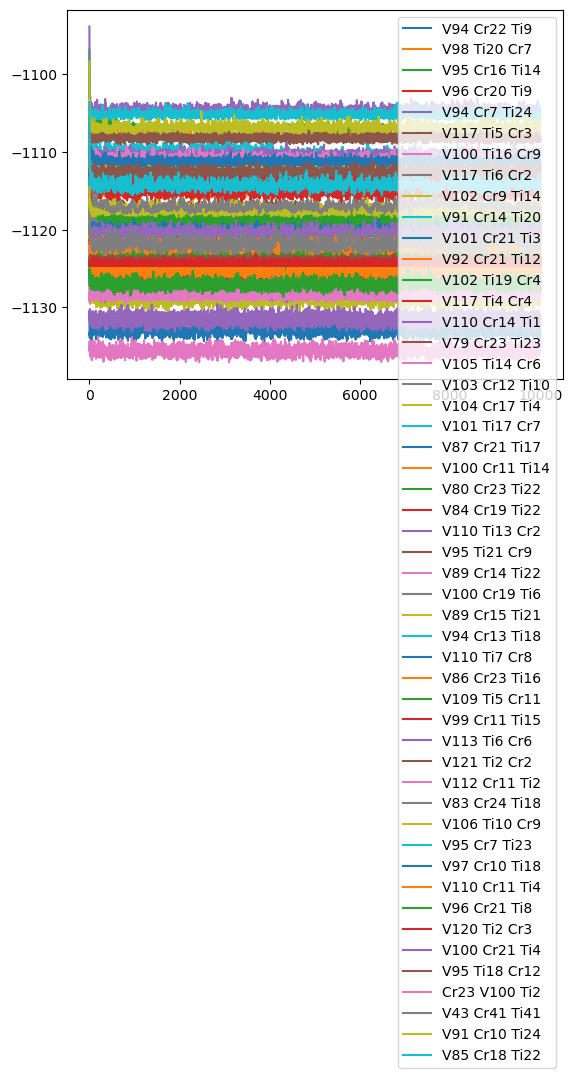

In [8]:
for i, expansion_path in enumerate(expansion_list):
    work = load_work(expansion_path)
    expansion = work['ClusterExpansion']
    # Create the ensemble
    # This specifies the size of the MC simulation domain.
    # this gives a 64 site unit cell
    sc_matrix = np.array([
        [5, 0, 0],
        [0, 5, 0],
        [0, 0, 5]
    ])
    # this convenience method will take care of creating the appropriate
    # processor for the given cluster expansion.
    #os.environ['OMP_NUM_THREADS'] = '4'
    ensemble = Ensemble.from_cluster_expansion(expansion, sc_matrix)
    ensemble.processor.num_threads_full = 5

    # In a real scenario you may want a much larger processor.size
    # An MC step is O(1) with the processor.size, meaning it runs at
    # the same speed regardless of the size. However, larger sizes
    # will need many more steps to reach equilibrium in an MC simulation.
    print(f'The supercell size for the processor is {ensemble.processor.size} prims.')
    print(f'The ensemble has a total of {ensemble.num_sites} sites.')
    print(f'The active sublattices are:')
    for sublattice in ensemble.sublattices:
        print(sublattice)


    # here we also set the temperature to our operating temperature, in V-Cr-Ti this should be around 900K 
    T_sample = 973.15
    sampler = Sampler.from_ensemble(ensemble, temperature=T_sample)
    print(f"Sampling information: {sampler.samples.metadata}")
    compositions = [sublattice.composition for sublattice in ensemble.sublattices]

    print(dir(sublattice))
    compositions = [sublattice.composition for sublattice in ensemble.sublattices]
    print(f'The compositions are {compositions}')
    try:
        # this will raise an error if the ensemble is not ordered
        init_occu = generate_random_ordered_occupancy(processor= ensemble.processor,
                                                    composition=compositions,
                                                    tol = 0.99,
                                                    rng=42)
    except:
        #raise ValueError('The ensemble is not ordered, please check the ensemble and try again.')
        print('The ensemble is not ordered, please check the ensemble and try again.')
        continue
    #init_occu = generate_random_ordered_occupancy(processor= ensemble.processor,
                                                #composition=compositions,
                                                #tol = 0.99,
                                                #rng=42)

    print(f"The disordered structure has composition: {ensemble.processor.structure.composition}")
    print(f"The initial occupancy has composition: {ensemble.processor.structure_from_occupancy(init_occu).composition}")

    print(f'The encoded occupancy is:\n{init_occu}')
    print(f'The initial occupancy is:\n {ensemble.processor.decode_occupancy(init_occu)}')

    # run 1M iterations
    # since this is the first run, the initial occupancy must be supplied
    sampler.run(
        1000000,
        initial_occupancies=init_occu,
        thin_by=100, # thin_by will save every 100th sample only
        progress=True
    ) # progress will show progress bar

    # Samples are saved in a sample container
    samples = sampler.samples

    print(f'Fraction of successful steps (efficiency) {sampler.efficiency()}')
    print(f'The last step energy is {samples.get_energies()[-1]} eV')
    print(f'The minimum energy in trajectory is {samples.get_minimum_energy()} eV')

    # You can get the minimum energy structure and current structure
    # by using the ensemble processor
    curr_s = ensemble.processor.structure_from_occupancy(samples.get_occupancies()[-1])
    min_s = ensemble.processor.structure_from_occupancy(samples.get_minimum_energy_occupancy())

    #from smol.moca.analysis.convergence import check_property_converged, determine_discard_number

    energies = samples.get_energies()
    # 100 as an initial guess for amount to discard
    #opt_discard = determine_discard_number(property_array=energies, init_discard=100, verbose=True)
    #converged = check_property_converged(energies[opt_discard:])
    #print(f'Is the energy converged after discarding the first {opt_discard} samples?', converged)
    print(energies)

    # let's plot the energy trajectories over time 

    import matplotlib.pyplot as plt
    runs = np.arange(len(energies))
    plt.plot(runs, energies,label=f'{ensemble.processor.structure_from_occupancy(init_occu).composition}')

    # Set 100 samples for burn-in, as determined in 5)
    discard = 100 # this is in terms of samples so it would be discard*thin_by steps
    print(f'A total of {len(samples)} samples taken.')
    print(f'A total of {len(samples.get_energies(discard=discard))} samples used for production.')
    print(f'The average energy is {samples.mean_energy(discard=discard)} eV')
    print(f'The energy variance is {samples.energy_variance(discard=discard)} eV^2')
    print(f'The sampling efficiency (acceptance rate) is approximately {samples.sampling_efficiency(discard=discard)}')


    #write these to cif files
    from pymatgen.io.cif import CifWriter
    structure_path = '../Visualization/Job_Structures/Pre_VASP/VCrTi_Fixed_125'

    initial_structure = samples.get_sampled_structures(indices=[0])[0]
    print(initial_structure)

    # ChANGE THE NAME 
    # get the composition of the structure
    composition = initial_structure.composition.reduced_formula

    # Find the start and end of the substring
    start = expansion_path.find('VCrTi_Fixed_125/') + len('VCrTi_Fixed_125/')
    end = expansion_path.find('_fin_work.mson')

    # Extract the substring
    substring = expansion_path[start:end]

    # write the initial structure to a CIF file
    cif = CifWriter(initial_structure)
    total_initial_path = os.path.join(structure_path, substring + '_initial.cif')
    cif.write_file(total_initial_path)

    # print the last structure 
    final_structure = samples.get_sampled_structures(indices=[-1])[0]
    print(final_structure)

    # write the final structure to a CIF file
    cif = CifWriter(final_structure)
    total_final_path = os.path.join(structure_path, substring + '_final.cif')
    cif.write_file(total_final_path)

    # instead of getting just the middle, pick 4 structures within the 25% and 75% quartile
    # Calculate the indices for the 25% and 75% quartiles
    # Calculate the indices for the 25% and 75% quartiles
    lower_quartile_index = len(samples) // 4
    upper_quartile_index = 3 * len(samples) // 4

    # Create a new list that contains only the elements between the 25% and 75% quartiles
    samp_range = np.arange(len(samples))

    # Check if samp_range is not empty
    if samp_range.size > 0:
        middle_samples = samp_range[lower_quartile_index:upper_quartile_index]
        # Randomly select 5 elements from the middle_samples list
        if len(middle_samples) >= 5:
            random_samples = random.sample(list(middle_samples), 5)
        else:
            print("Not enough samples for random selection.")
    else:
        print("samp_range is empty.")
    for samp in random_samples: 
        mid_structure = samples.get_sampled_structures(indices=[samp])[0]
        # write the middle structure to a CIF file
        cif = CifWriter(mid_structure)
        total_middle_path = os.path.join(structure_path, substring + '_middle_' + str(samp) + '.cif')
        cif.write_file(total_middle_path)
    
    #cif = CifWriter(middle_structure)
    #total_middle_path = os.path.join(structure_path, substring + '_middle.cif')
    #cif.write_file(total_middle_path)
    # save the Sample container with the same name 
    total_sample_path = os.path.join(structure_path, substring + '_samples.mson')

    save_work(total_sample_path,samples)

plt.legend()
plt.show()

In [7]:
# pick random structure within the middle quartiles of the runsteps from the samples and write to cif file
middle_quartile = len(samples)//4
print(samples)
# get teh structure from the middle quartile
middle_structure = samples.get_sampled_structures(indices=[middle_quartile])[0]
print(middle_structure)
# write the middle structure to a CIF file
cif = CifWriter(middle_structure)
total_middle_path = os.path.join(structure_path, substring + '_middle.cif')
cif.write_file(total_middle_path)

Full Formula (Ti24 V464 Cr24)
Reduced Formula: Ti3V58Cr3
abc   :  20.853892  20.853892  20.853892
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (512)
  #  SP        a      b      c
---  ----  -----  -----  -----
  0  V     0      0      0
  1  V     0      0      0.125
  2  V     0      0      0.25
  3  V     0      0      0.375
  4  V     0      0      0.5
  5  V     0      0      0.625
  6  V     0      0      0.75
  7  V     0      0      0.875
  8  V     0      0.125  0
  9  V     0      0.125  0.125
 10  V     0      0.125  0.25
 11  V     0      0.125  0.375
 12  V     0      0.125  0.5
 13  V     0      0.125  0.625
 14  V     0      0.125  0.75
 15  V     0      0.125  0.875
 16  V     0      0.25   0
 17  V     0      0.25   0.125
 18  V     0      0.25   0.25
 19  V     0      0.25   0.375
 20  V     0      0.25   0.5
 21  V     0      0.25   0.625
 22  V     0      0.25   0.75
 23  V     0      0.25   0.875
 24  V     0      0.375  0

In [25]:
import os
import numpy as np
from smol.io import load_work
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
import json

# Directory containing the .mson files
directory = '../Visualization/Job_Structures/Pre_VASP/VCrTi_fixed_64'

# Initialize an empty list to store the computed structure entries
computed_entries = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mson'):
        filepath = os.path.join(directory, filename)
        
        # Load the sample data from the .mson file
        samples = load_work(filepath)
        
        # Get the energies and structures
        energies = samples['SampleContainer'].get_energies()
        # Get the minimum energy and corresponding structure
        min_energy_index = np.argmin(energies)
        min_energy = energies[min_energy_index]

        min_structure = samples['SampleContainer'].get_sampled_structures(indices=[min_energy_index])[0]
        #min_structure = structures[min_energy_index]
                
        # Create a ComputedStructureEntry for the minimum energy structure
        min_entry = ComputedStructureEntry(structure=min_structure, energy=min_energy)
        
        # Append the entry to the list
        computed_entries.append(min_entry)

# Convert the list of entries to a JSON serializable format
entries_dict = [entry.as_dict() for entry in computed_entries]

# Save the list as a JSON file
output_filepath = '../Entries/post_mcmc_vcrti_entries.json'
with open(output_filepath, 'w') as f:
    json.dump(entries_dict, f)

print(f"Saved computed entries to {output_filepath}")


Saved computed entries to ../Entries/post_mcmc_vcrti_entries.json
